<a href="https://colab.research.google.com/github/kotalaraghava/END-2.0---school-of-ai/blob/master/session_7/Sentiment_Analysis_using_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 TorchText

## Dataset Preview

Your first step to deep learning in NLP. We will be mostly using PyTorch. Just like torchvision, PyTorch provides an official library, torchtext, for handling text-processing pipelines. 

We will be using previous session tweet dataset. Let's just preview the dataset.

In [1]:
!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip

!unzip stanfordSentimentTreebank.zip

--2021-06-24 16:51:26--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-06-24 16:51:27--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  3.04MB/s    in 2.0s    

2021-06-24 16:51:29 (3.04 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]

Archive:  stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: 

In [2]:
import os
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [90]:
def mapping_output(x):
  if 0<x<0.2:
    return 0
  elif 0.2<x<0.4:
    return 1
  elif 0.4<x<0.6:
    return 2
  elif 0.6<x<0.8:
    return 3
  else:
    return 4

In [91]:
sst_dir = 'stanfordSentimentTreebank'

sentiment_labels = pd.read_csv(os.path.join(sst_dir, "sentiment_labels.txt"), names=['phrase_ids', 'sentiment_values'], sep="|", header=0)
sentiment_labels['sentiment_values'] = sentiment_labels['sentiment_values'].apply(mapping_output)
sentence_ids = pd.read_csv(os.path.join(sst_dir, "datasetSentences.txt"), sep="\t")

dictionary = pd.read_csv(os.path.join(sst_dir, "dictionary.txt"), sep="|", names=['phrase', 'phrase_ids'])
train_test_split = pd.read_csv(os.path.join(sst_dir, "datasetSplit.txt"))
sentence_phrase_merge = pd.merge(sentence_ids, dictionary, left_on='sentence', right_on='phrase')
sentence_phrase_split = pd.merge(sentence_phrase_merge, train_test_split, on='sentence_index')
dataset = pd.merge(sentence_phrase_split, sentiment_labels, on='phrase_ids')
dataset.rename(columns={'sentiment_values': 'labels'}, inplace=True)
dataset['phrase_cleaned'] = dataset['sentence'].str.replace(r"\s('s|'d|'re|'ll|'m|'ve|n't)\b", lambda m: m.group(1))
test_size = 0.3 * dataset.shape[0]
df_test = dataset.sample(round(test_size))

df = dataset[~dataset.index.isin(test_df.index)]
test_df.shape, df.shape

((3386, 7), (7900, 7))

In [47]:
import seaborn as sns

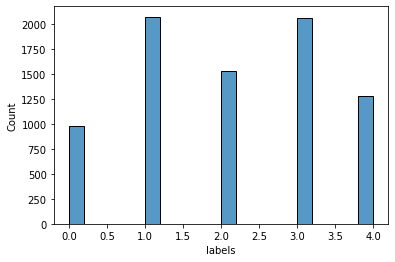

In [48]:
sns.histplot(x='labels', data=df)

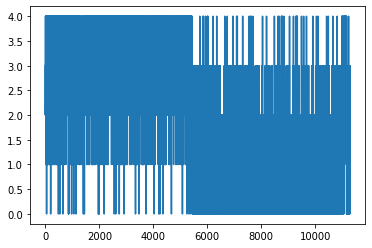

In [49]:
df['labels'].plot()

In [51]:
df_test.head()

,sentence_index,sentence,phrase,phrase_ids,splitset_label,labels,phrase_cleaned
4744,4962,A remarkably alluring film set in the constric...,A remarkably alluring film set in the constric...,103846,1,3,A remarkably alluring film set in the constric...
7629,7988,"For the most part , the ingredients are there .","For the most part , the ingredients are there .",223405,2,2,"For the most part , the ingredients are there ."
929,960,"It is ridiculous , of course ... but it is als...","It is ridiculous , of course ... but it is als...",25794,2,3,"It is ridiculous , of course ... but it is als..."
4474,4678,"A serviceable Euro-trash action extravaganza ,...","A serviceable Euro-trash action extravaganza ,...",222090,1,2,"A serviceable Euro-trash action extravaganza ,..."
8826,9243,"For all the time we spend with these people , ...","For all the time we spend with these people , ...",183979,1,1,"For all the time we spend with these people , ..."


In [52]:
df_test.shape

(3386, 7)

## Defining Fields

Now we shall be defining LABEL as a LabelField, which is a subclass of Field that sets sequen tial to False (as it’s our numerical category class). TWEET is a standard Field object, where we have decided to use the spaCy tokenizer and convert all the text to lower‐ case.

In [53]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data 

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [54]:
Tweet = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [55]:
fields = [('tweets', Tweet),('labels',Label)]

Armed with our declared fields, lets convert from pandas to list to torchtext. We could also use TabularDataset to apply that definition to the CSV directly but showing an alternative approach too.

In [56]:
df.head()

,sentence_index,sentence,phrase,phrase_ids,splitset_label,labels,phrase_cleaned
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166,1,3,The Rock is destined to be the 21st Century's ...
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300,1,4,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,13995,2,2,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,14123,2,3,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...",13999,2,4,"Emerges as something rare , an issue movie tha..."


In [57]:
df_test.head()

,sentence_index,sentence,phrase,phrase_ids,splitset_label,labels,phrase_cleaned
4744,4962,A remarkably alluring film set in the constric...,A remarkably alluring film set in the constric...,103846,1,3,A remarkably alluring film set in the constric...
7629,7988,"For the most part , the ingredients are there .","For the most part , the ingredients are there .",223405,2,2,"For the most part , the ingredients are there ."
929,960,"It is ridiculous , of course ... but it is als...","It is ridiculous , of course ... but it is als...",25794,2,3,"It is ridiculous , of course ... but it is als..."
4474,4678,"A serviceable Euro-trash action extravaganza ,...","A serviceable Euro-trash action extravaganza ,...",222090,1,2,"A serviceable Euro-trash action extravaganza ,..."
8826,9243,"For all the time we spend with these people , ...","For all the time we spend with these people , ...",183979,1,1,"For all the time we spend with these people , ..."


In [58]:
df = df.reset_index()
df_test = df_test.reset_index()

In [59]:
example_train = [data.Example.fromlist([df.sentence[i],df.labels[i]], fields) for i in range(df.shape[0])] 

In [60]:
df.sentence[0]

"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."

In [63]:
example_test = [data.Example.fromlist([df_test.sentence[i], df_test.labels[i]], fields) for i in range(df_test.shape[0])]

In [64]:
# Creating dataset
#twitterDataset = data.TabularDataset(path="tweets.csv", format="CSV", fields=fields, skip_header=True)

valid = data.Dataset(example_test, fields)
train = data.Dataset(example_train, fields)

Finally, we can split into training, testing, and validation sets by using the split() method:

In [65]:
(len(train), len(valid))

(7900, 3386)

An example from the dataset:

In [66]:
vars(train.examples[1])

{'labels': 4,
 'tweets': ['The',
  'gorgeously',
  'elaborate',
  'continuation',
  'of',
  '`',
  '`',
  'The',
  'Lord',
  'of',
  'the',
  'Rings',
  "''",
  'trilogy',
  'is',
  'so',
  'huge',
  'that',
  'a',
  'column',
  'of',
  'words',
  'can',
  'not',
  'adequately',
  'describe',
  'co',
  '-',
  'writer\\/director',
  'Peter',
  'Jackson',
  "'s",
  'expanded',
  'vision',
  'of',
  'J.R.R.',
  'Tolkien',
  "'s",
  'Middle',
  '-',
  'earth',
  '.']}

## Building Vocabulary

At this point we would have built a one-hot encoding of each word that is present in the dataset—a rather tedious process. Thankfully, torchtext will do this for us, and will also allow a max_size parameter to be passed in to limit the vocabu‐ lary to the most common words. This is normally done to prevent the construction of a huge, memory-hungry model. We don’t want our GPUs too overwhelmed, after all. 

Let’s limit the vocabulary to a maximum of 5000 words in our training set:


In [67]:
Tweet.build_vocab(train)
Label.build_vocab(train)

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [68]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  16288
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 7444), (',', 6487), ('the', 5650), ('and', 4066), ('a', 4039), ('of', 4038), ('to', 2788), ('-', 2498), ('is', 2333), ("'s", 2286)]
Labels :  defaultdict(None, {1: 0, 3: 1, 2: 2, 4: 3, 0: 4})


**Lots of stopwords!!**

Now we need to create a data loader to feed into our training loop. Torchtext provides the BucketIterator method that will produce what it calls a Batch, which is almost, but not quite, like the data loader we used on images.

But at first declare the device we are using.

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweets),
                                                            sort_within_batch=True, device = device)

Save the vocabulary for later use

In [71]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

## Defining Our Model

We use the Embedding and LSTM modules in PyTorch to build a simple model for classifying tweets.

In this model we create three layers. 
1. First, the words in our tweets are pushed into an Embedding layer, which we have established as a 300-dimensional vector embedding. 
2. That’s then fed into a 2 stacked-LSTMs with 100 hidden features (again, we’re compressing down from the 300-dimensional input like we did with images). We are using 2 LSTMs for using the dropout.
3. Finally, the output of the LSTM (the final hidden state after processing the incoming tweet) is pushed through a standard fully connected layer with three outputs to correspond to our three possible classes (negative, positive, or neutral).

In [72]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [73]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 5
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [74]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(16288, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)
The model has 5,128,505 trainable parameters


## Model Training and Evaluation

First define the optimizer and loss functions

In [75]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

The main thing to be aware of in this new training loop is that we have to reference `batch.tweets` and `batch.labels` to get the particular fields we’re interested in; they don’t fall out quite as nicely from the enumerator as they do in torchvision.

**Training Loop**

In [76]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweets   
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Evaluation Loop**

In [77]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweets
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Let's Train and Evaluate**

In [89]:
N_EPOCHS = 10
best_valid_loss = float('inf')
train_li = []
test_li = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    train_li.append(train_acc*100)
    test_li.append(valid_acc*100)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Test. Loss: {valid_loss:.3f} |  Test. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 0.977 | Train Acc: 92.81%
	 Test. Loss: 1.147 |  Test. Acc: 75.33% 

	Train Loss: 0.975 | Train Acc: 92.92%
	 Test. Loss: 1.144 |  Test. Acc: 75.68% 

	Train Loss: 0.972 | Train Acc: 93.21%
	 Test. Loss: 1.140 |  Test. Acc: 76.07% 

	Train Loss: 0.970 | Train Acc: 93.39%
	 Test. Loss: 1.139 |  Test. Acc: 76.21% 

	Train Loss: 0.970 | Train Acc: 93.48%
	 Test. Loss: 1.139 |  Test. Acc: 76.21% 

	Train Loss: 0.969 | Train Acc: 93.56%
	 Test. Loss: 1.139 |  Test. Acc: 76.06% 

	Train Loss: 0.968 | Train Acc: 93.60%
	 Test. Loss: 1.140 |  Test. Acc: 76.00% 

	Train Loss: 0.972 | Train Acc: 93.38%
	 Test. Loss: 1.143 |  Test. Acc: 75.79% 

	Train Loss: 0.978 | Train Acc: 92.87%
	 Test. Loss: 1.143 |  Test. Acc: 75.79% 

	Train Loss: 0.973 | Train Acc: 93.36%
	 Test. Loss: 1.140 |  Test. Acc: 76.00% 



In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

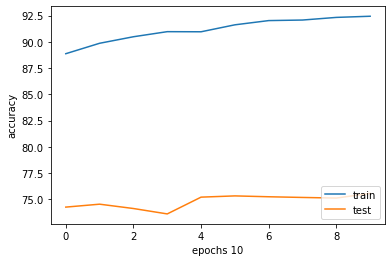

In [86]:
plt.plot(range(0,10), train_li)
plt.xlabel('epochs 10')
plt.ylabel('accuracy')
plt.plot(range(0,10), test_li)
plt.legend(["train", "test"], loc ="lower right")

## Model Testing

In [87]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    categories = {0: "Very negative", 1:"negative", 2:"Neutral",
                  3 : 'positive', 4:'very positive'}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [83]:
for a in df_test.sentence[:10]:
  print('Text: ', a, 'Prediction: ',classify_tweet(a))

Text:  A remarkably alluring film set in the constrictive Eisenhower era about one suburban woman 's yearning in the face of a loss that shatters her cheery and tranquil suburban life . Prediction:  negative
Text:  For the most part , the ingredients are there . Prediction:  Neutral
Text:  It is ridiculous , of course ... but it is also refreshing , disarming , and just outright enjoyable despite its ridiculousness . Prediction:  negative
Text:  A serviceable Euro-trash action extravaganza , with a decent sense of humor and plenty of things that go boom -- handguns , BMWs and seaside chateaus . Prediction:  Neutral
Text:  For all the time we spend with these people , we never really get inside of them . Prediction:  negative
Text:  Whether our action-and-popcorn obsessed culture will embrace this engaging and literate psychodrama is n't much of a mystery , unfortunately . Prediction:  Very negative
Text:  A whale of a good time for both children and parents seeking Christian-themed fun

In [ ]:
df_test.sentences[50]